# MINI PROJET 1: Qui a peint ce tableau ?

In [1]:
# Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image


# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# tf.config.list_physical_devices()
[k.device_type for k in tf.config.list_physical_devices()]

['CPU', 'GPU']

## Preparation du jeu de données

In [3]:
# Vérifie si le dossier "data" existe, et le supprime s'il est présent.
#if os.path.exists("data"):
#    shutil.rmtree("data")  # Supprime le dossier et tout son contenu

# Définition du chemin vers le dossier contenant les images des auteurs.
path = "./images_hq/"

# Initialisation d'une liste pour stocker les labels (noms d'auteurs).
labels = []

# Si le dossier "data" n'existe pas, il est créé.
if not os.path.exists("data"):
    os.mkdir("data")  # Crée un nouveau dossier "data"

# Parcours du contenu du dossier `path` (dossier contenant les sous-dossiers d'auteurs).
for author_folder in os.listdir(path):
    # Pour chaque sous-dossier d'auteur, obtient le chemin complet.
    author_path = os.path.join(path, author_folder)
    
    # Parcours de chaque image dans le sous-dossier de l'auteur.
    for image_filename in os.listdir(author_path):
        # Initialisation d'une chaîne vide pour stocker le nom de l'auteur.
        author_name = ""
        
        # Séparation du nom de fichier selon les underscores ('_'), pour reconstruire le nom de l'auteur.
        # L'image est supposée être nommée avec le format "prénom_nom_numéro.jpg"
        # On extrait ici toutes les parties du nom avant le dernier underscore.
        for i in range(len(image_filename.split('_')) - 1):
            author_name += image_filename.split('_')[i] 
            # La ligne suivante (en commentaire) sert à tester ou déboguer si nécessaire
            #print(author_name, author_folder)
    
        # Copie le fichier d'image depuis son emplacement d'origine vers le dossier "data".
        src = os.path.join(author_path, image_filename)  # Chemin source
        dst = os.path.join("data/", image_filename)  # Chemin destination
        shutil.copyfile(src, dst)  # Copie le fichier d'origine vers la destination
        
        # Ajoute le nom de l'auteur à la liste des labels.
        labels.append(author_name)

# Liste tous les fichiers dans le dossier "data", qui sont les fichiers d'image copiés.
train_filename = os.listdir("data")

In [4]:
total_df = pd.DataFrame({
    'filename': train_filename,
    'category': labels
})

In [6]:
total_df.shape

(8446, 2)

In [7]:
sorted_data = total_df.iloc[:, 1].value_counts(ascending=False)
sorted_data

category
VincentvanGogh             877
EdgarDegas                 702
PabloPicasso               439
Pierre-AugusteRenoir       336
AlbrechtDürer              328
PaulGauguin                311
FranciscoGoya              291
Rembrandt                  262
AlfredSisley               259
Titian                     255
MarcChagall                239
ReneMagritte               194
AmedeoModigliani           193
PaulKlee                   188
HenriMatisse               186
AndyWarhol                 181
MikhailVrubel              171
SandroBotticelli           164
LeonardodaVinci            143
PeterPaulRubens            141
SalvadorDali               139
HieronymusBosch            137
PieterBruegel              134
DiegoVelazquez             128
KazimirMalevich            126
FridaKahlo                 120
GiottodiBondone            119
GustavKlimt                117
Raphael                    109
JoanMiro                   102
AndreiRublev                99
CamillePissarro             91

Nous constatons que nos données présentent un déséquilibre dans la répartition des étiquettes. Cela peut entraîner :
   + Déséquilibre de la précision entre les classes : Lorsque certaines classes ont beaucoup moins d'exemples que d'autres, le modèle CNN peut biaiser ses prédictions en faveur des classes les plus représentées. Cela signifie que le modèle aura une précision moindre pour les classes sous-représentées.
   + Réduction de la précision globale et de la capacité de généralisation : Un déséquilibre des classes peut empêcher le modèle d'apprendre correctement les caractéristiques des classes minoritaires, réduisant ainsi sa capacité de généralisation. Le modèle peut afficher une précision globale élevée, mais cela ne reflète pas sa réelle efficacité pour les classes moins fréquentes.
   + Augmentation du risque de surapprentissage (overfitting) pour les classes minoritaires : Lorsque les classes minoritaires ont très peu d'exemples, le modèle risque de surapprendre ces échantillons spécifiques sans généraliser correctement. Cela signifie que le modèle pourra reconnaître ces exemples en particulier, mais sera inefficace avec des exemples nouveaux appartenant aux mêmes classes.


## Visualisation des images

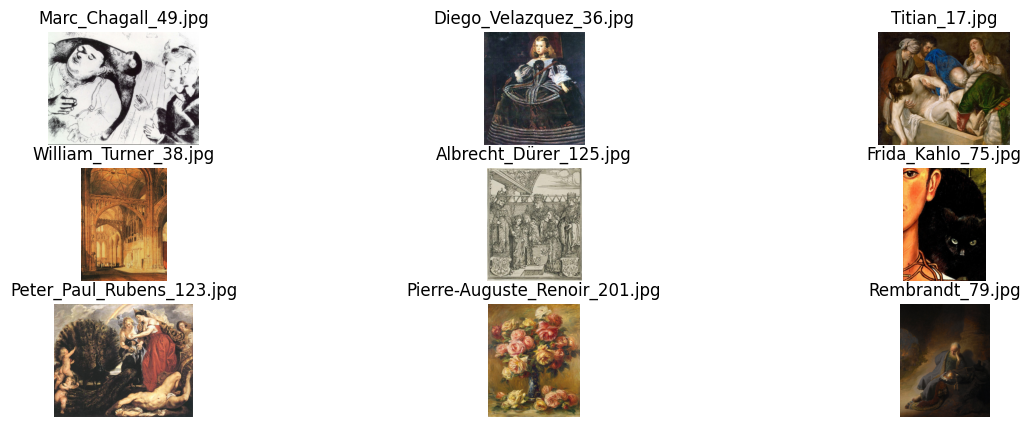

In [8]:
from tensorflow.keras.utils import load_img, img_to_array
fig,axe=plt.subplots(3,3,figsize=(15,5))

for i in range(3):
    for j in range(3):
        filename = rd.choice(total_df['filename'])
        img = load_img("data/" + filename)

          # Sélectionne une image appartenant à la classe k
        
        # Affiche l'image sur l'axe correspondant
        axe[i, j].imshow(img)  # Ajuster cmap selon vos images (ex: 'gray' pour images en niveaux de gris)
        axe[i, j].set_title(filename)  # Ajoute un titre pour chaque sous-graphe
        axe[i, j].axis('off')
    

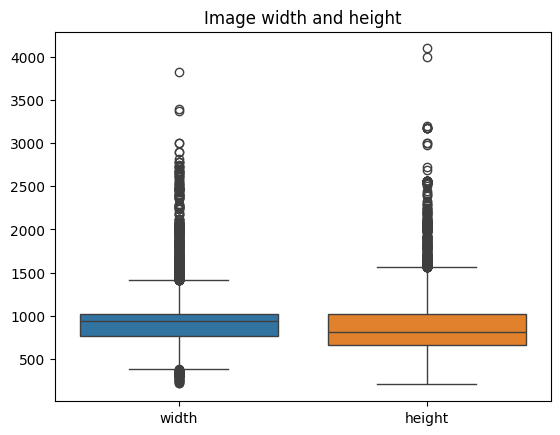

In [9]:
img_size = np.zeros((total_df.shape[0],2))
for i, filename in enumerate(total_df['filename']) :
    img = img_to_array( load_img("data/"+filename) )
    img_size[i,:] = img.shape[:2]

# --- #

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()


## Pretraitement

In [10]:
total_df.columns

Index(['filename', 'category'], dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Encode the 'category' column
total_df['category_encoded'] = label_encoder.fit_transform(total_df['category'])

# Display the updated DataFrame
total_df.head()

In [37]:
from sklearn.model_selection import train_test_split

# Sépare le dataset 'total_df' en deux sous-ensembles : un ensemble d'entraînement (train_df) et un ensemble de test (test_df).
# La taille de l'ensemble de test est de 20% du dataset total.
train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)

# Sépare ensuite l'ensemble d'entraînement (train_df) en deux sous-ensembles : un ensemble d'entraînement (train_df) et un ensemble de validation (val_df).
# La taille de l'ensemble de validation est de 25% de l'ensemble d'entraînement initial (soit 25% de 80%, ce qui correspond à 20% du dataset total).
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 20 # Nombre d'images à traiter à chaque itération de l'entraînement.
img_width = 150 # Largeur cible des images après redimensionnement.
img_height = 150 # Hauteur cible des images après redimensionnement.

# Crée un générateur d'images pour l'ensemble d'entraînement en normalisant les pixels (valeurs entre 0 et 1).
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)


Found 5067 validated image filenames belonging to 50 classes.
Found 1689 validated image filenames belonging to 50 classes.
Found 1690 validated image filenames belonging to 50 classes.


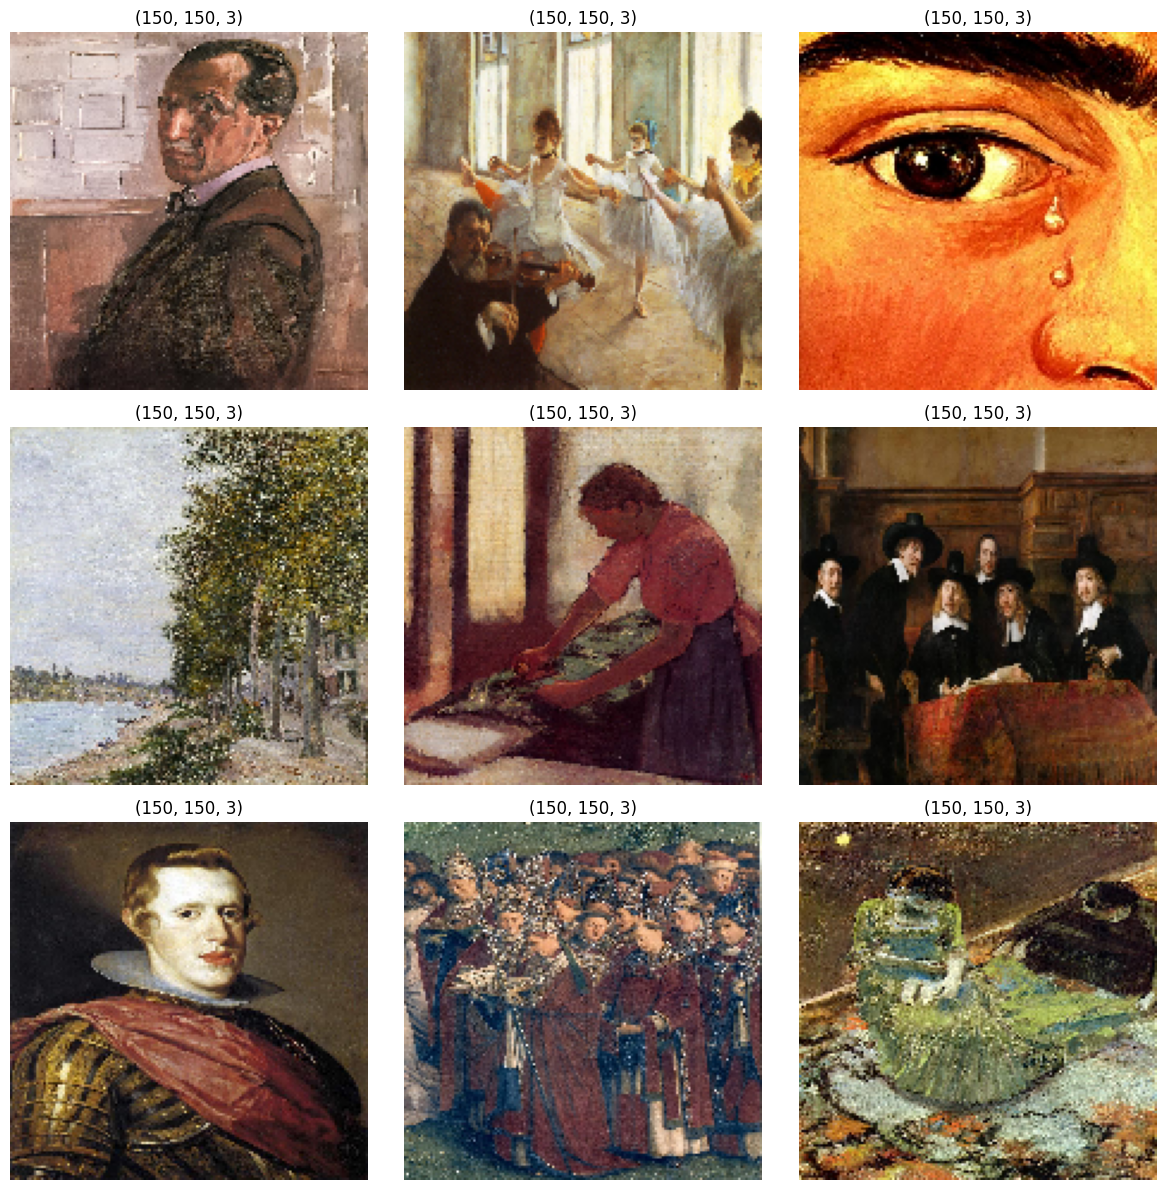

In [39]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        
        plt.title(str(img.shape))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break

plt.tight_layout()
plt.show()

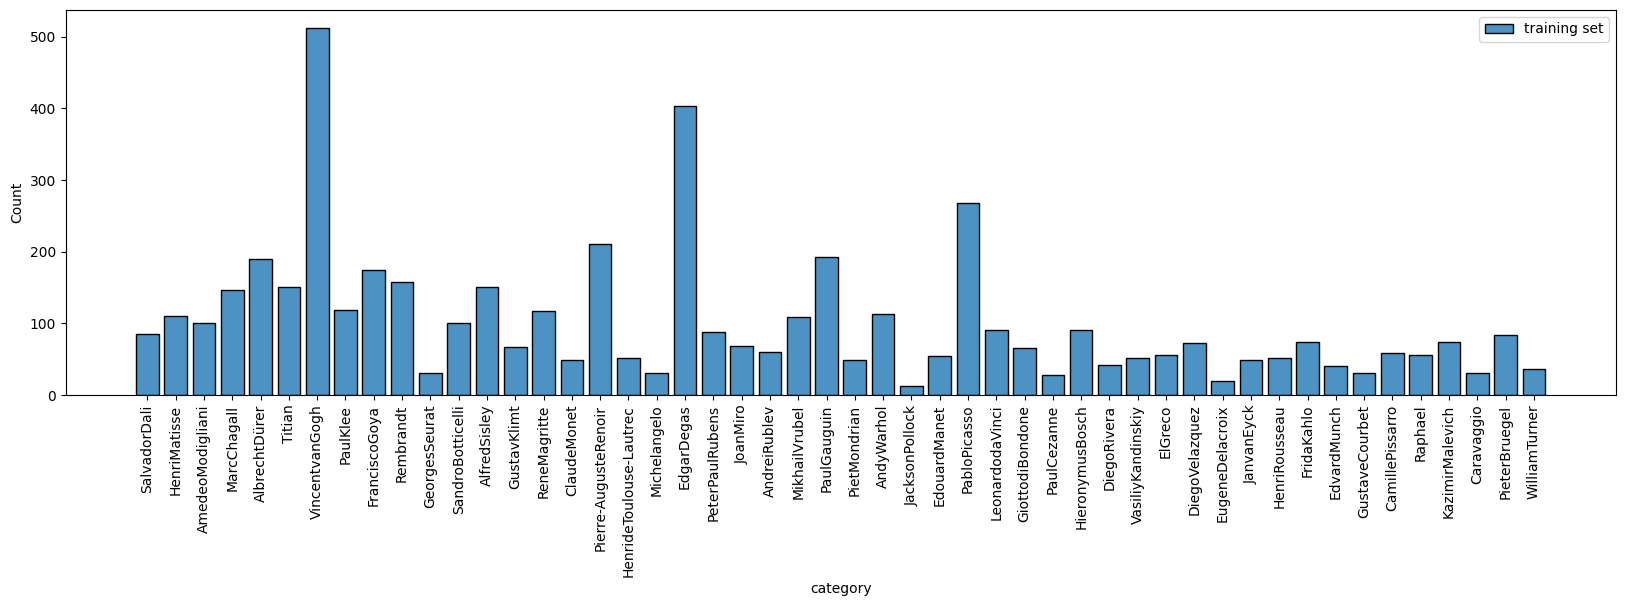

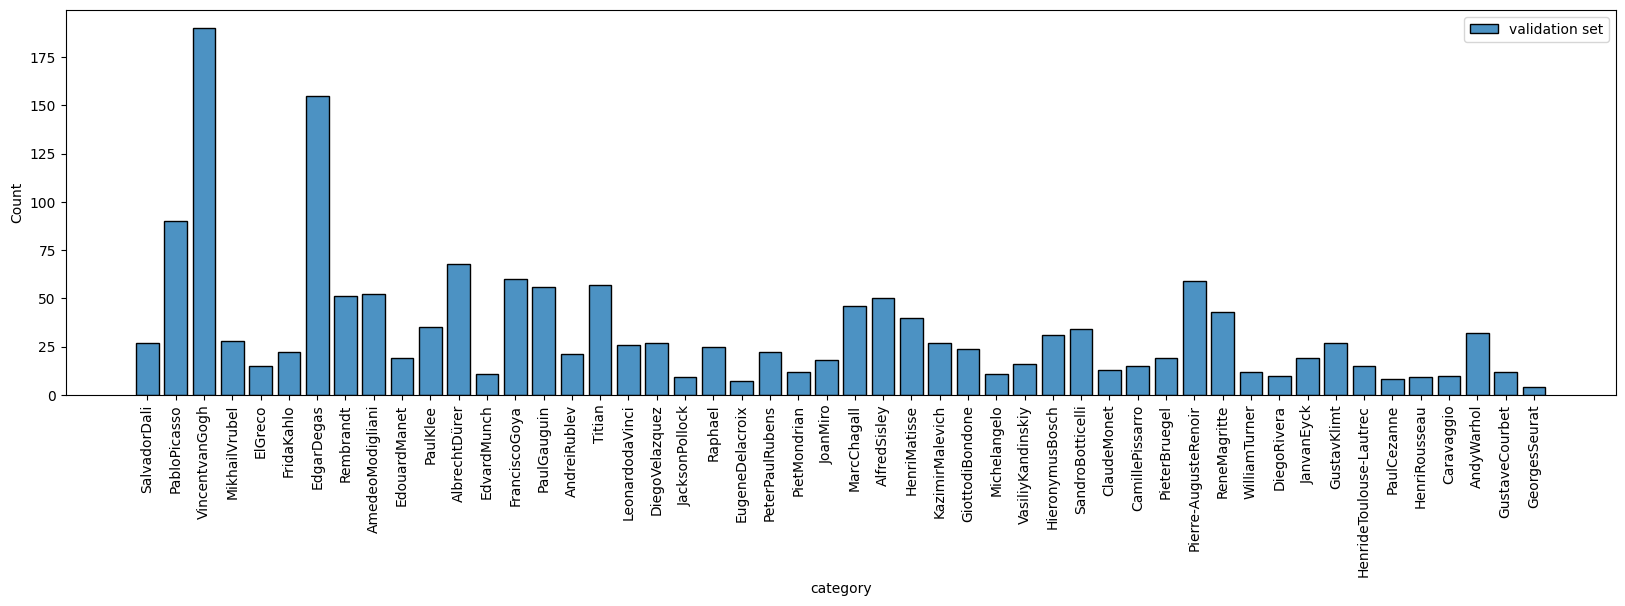

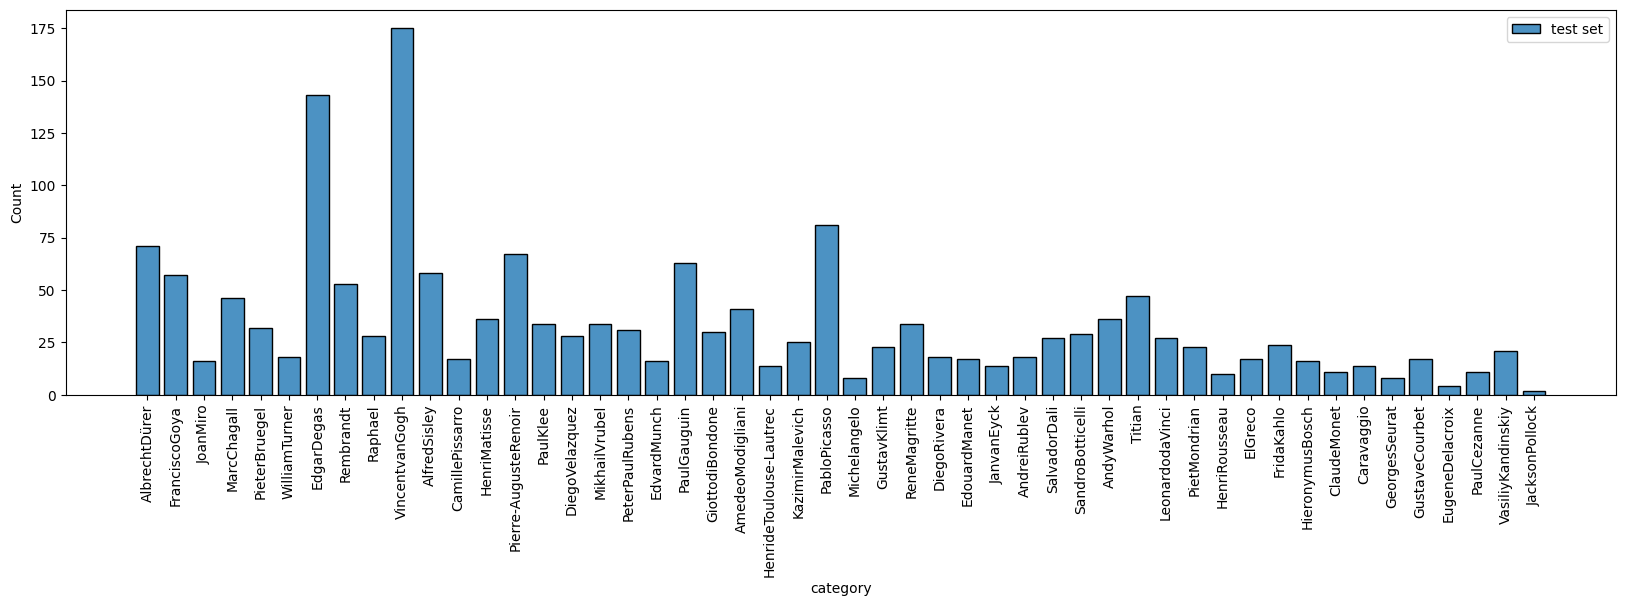

In [42]:
plt.figure(figsize=(20,5))

sns.histplot(train_df.iloc[:,1],label="training set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()
plt.figure(figsize=(20,5))
sns.histplot(val_df.iloc[:,1],label="validation set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()
plt.figure(figsize=(20,5))
sns.histplot(test_df.iloc[:,1],label="test set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()

## First approach: Basic convolutional network

In [15]:
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(150,150, 3)))
cnn_simple.add(Conv2D(32, kernel_size=(3, 3), activation='relu', data_format="channels_last"))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Flatten())    # Vectorization of the tensor to connect it to a dense layer
cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(50, activation='softmax'))

cnn_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 96)       0

In [16]:
cnn_simple.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

In [17]:
epochs = 10

t_learning_cnn_simple = time.time()
cnn_simple_history = cnn_simple.fit(
    train_generator,
    validation_data = val_generator,
    epochs = epochs
)
t_learning_cnn_simple = time.time() - t_learning_cnn_simple

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple))

Epoch 1/10
254/254 [==============================] - 39s 122ms/step - loss: 3.8063 - accuracy: 0.0639 - val_loss: 3.7016 - val_accuracy: 0.0918
Epoch 2/10
254/254 [==============================] - 30s 119ms/step - loss: 3.6960 - accuracy: 0.0894 - val_loss: 3.4955 - val_accuracy: 0.1989
Epoch 3/10
254/254 [==============================] - 30s 119ms/step - loss: 3.5947 - accuracy: 0.1208 - val_loss: 3.4120 - val_accuracy: 0.1906
Epoch 4/10
254/254 [==============================] - 30s 119ms/step - loss: 3.4743 - accuracy: 0.1500 - val_loss: 3.2820 - val_accuracy: 0.2173
Epoch 5/10
254/254 [==============================] - 30s 119ms/step - loss: 3.3996 - accuracy: 0.1577 - val_loss: 3.1454 - val_accuracy: 0.2356
Epoch 6/10
254/254 [==============================] - 30s 118ms/step - loss: 3.3395 - accuracy: 0.1774 - val_loss: 3.1310 - val_accuracy: 0.2433
Epoch 7/10
254/254 [==============================] - 33s 130ms/step - loss: 3.2790 - accuracy: 0.1828 - val_loss: 3.0453 - val_ac

In [81]:
t_prediction_cnn_simple = time.time()

score_cnn_train = cnn_simple.evaluate(train_generator, verbose=1)
score_cnn_validation = cnn_simple.evaluate(val_generator, verbose=1)

t_prediction_cnn_simple = time.time() - t_prediction_cnn_simple

print('Train accuracy:', score_cnn_train[1])
print('Validation accuracy:', score_cnn_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_cnn_simple )

85/85 [==============================] - 8s 92ms/step - loss: 2.8260 - accuracy: 0.2895
Train accuracy: 0.3130057156085968
Validation accuracy: 0.28952041268348694
Time Prediction: 32.27 seconds


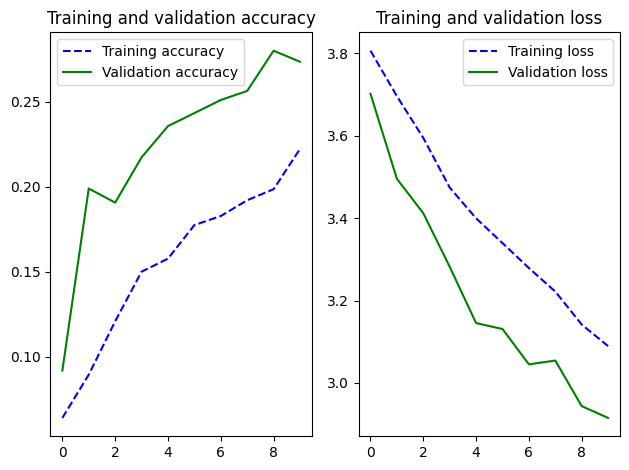

In [60]:
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_analysis(cnn_simple_history)

In [85]:
# Obtenez les prédictions du modèle sur l'ensemble de test
predictions = cnn_simple.predict(test_generator)

# Convertissez les prédictions en labels (en prenant l'index avec la plus haute probabilité)
predicted_classes = np.argmax(predictions, axis=1)

# Obtenez les vraies étiquettes à partir du générateur
true_classes = test_generator.classes

# Obtenez les noms de classes (catégories/étiquettes)
class_labels = list(test_generator.class_indices.keys())

85/85 [==============================] - 17s 199ms/step


In [89]:
from sklearn.metrics import accuracy_score, classification_report

# Créez un rapport de classification avec précision, rappel et F1-score pour chaque catégorie
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convertir le rapport de classification en DataFrame pour faciliter la manipulation
report_df = pd.DataFrame(report).transpose()

# Extraire seulement la colonne 'f1-score' et trier par ordre décroissant
sorted_f1_score = report_df[['f1-score']].sort_values(by='f1-score', ascending=False)

# Afficher le résultat
print(sorted_f1_score)

                         f1-score
VincentvanGogh           0.140260
EdgarDegas               0.134293
AlbrechtDürer            0.103774
DiegoRivera              0.095238
AndyWarhol               0.092308
accuracy                 0.054438
HieronymusBosch          0.048780
LeonardodaVinci          0.046512
AlfredSisley             0.044693
weighted avg             0.044190
DiegoVelazquez           0.040816
SandroBotticelli         0.035714
HenriMatisse             0.032258
FranciscoGoya            0.031496
Titian                   0.031008
Rembrandt                0.031008
Pierre-AugusteRenoir     0.030303
PaulKlee                 0.027778
PabloPicasso             0.026144
macro avg                0.020029
PaulGauguin              0.009050
AmedeoModigliani         0.000000
PieterBruegel            0.000000
PeterPaulRubens          0.000000
PietMondrian             0.000000
ReneMagritte             0.000000
Raphael                  0.000000
WilliamTurner            0.000000
SalvadorDali  

c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
# Encodage One-Hot de la colonne 'auteur'
total_df_ohe = pd.get_dummies(total_df, columns=["category"])
total_df.head()

filename       category
0    Albrecht_Dürer_1.jpg  AlbrechtDürer
1   Albrecht_Dürer_10.jpg  AlbrechtDürer
2  Albrecht_Dürer_100.jpg  AlbrechtDürer
3  Albrecht_Dürer_101.jpg  AlbrechtDürer
4  Albrecht_Dürer_102.jpg  AlbrechtDürer

filename       category  category_encoded
0    Albrecht_Dürer_1.jpg  AlbrechtDürer                 0
1   Albrecht_Dürer_10.jpg  AlbrechtDürer                 0
2  Albrecht_Dürer_100.jpg  AlbrechtDürer                 0
3  Albrecht_Dürer_101.jpg  AlbrechtDürer                 0
4  Albrecht_Dürer_102.jpg  AlbrechtDürer                 0

In [33]:
total_df.category_encoded.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20, 19, 23, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 40, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [43]:
from tensorflow.keras.applications import VGG16

In [44]:
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [45]:
train_features = conv_base.predict(train_generator)
train_features = np.reshape(train_features,(train_features.shape[0], -1))

validation_features = conv_base.predict(val_generator)
validation_features = np.reshape(validation_features,(validation_features.shape[0], -1))

85/85 [==============================] - 9s 105ms/step


In [48]:
train_data = train_df.to_numpy()
y_train = np.array([int(numeric_string) for numeric_string in train_data[:,2]])

validation_data = val_df.to_numpy()
y_validation = np.array([int(numeric_string) for numeric_string in validation_data[:,2]])

In [56]:
vgg_mlp = Sequential()
vgg_mlp.add( Input((train_features.shape[1],)) )
vgg_mlp.add(Dense(256, activation='relu'))
vgg_mlp.add(Dropout(0.5))
vgg_mlp.add(Dense(50, activation='softmax'))

vgg_mlp.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 50)                12850     
                                                                 
Total params: 2,110,258
Trainable params: 2,110,258
Non-trainable params: 0
_________________________________________________________________


In [57]:
epochs = 50

vgg_mlp.compile(
    loss = 'SparseCategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_mlp = time.time()
vgg_mlp_history = vgg_mlp.fit(
    train_features, y_train,
    validation_data = (validation_features, y_validation),
    epochs = epochs
)
t_learning_vgg_mlp = time.time() - t_learning_vgg_mlp

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_mlp))

Epoch 1/50
159/159 [==============================] - 1s 6ms/step - loss: 3.8107 - accuracy: 0.0821 - val_loss: 3.6489 - val_accuracy: 0.1089
Epoch 2/50
159/159 [==============================] - 1s 4ms/step - loss: 3.6883 - accuracy: 0.0878 - val_loss: 3.6307 - val_accuracy: 0.1131
Epoch 3/50
159/159 [==============================] - 1s 4ms/step - loss: 3.6322 - accuracy: 0.0985 - val_loss: 3.6306 - val_accuracy: 0.0977
Epoch 4/50
159/159 [==============================] - 1s 4ms/step - loss: 3.5825 - accuracy: 0.1064 - val_loss: 3.6108 - val_accuracy: 0.1143
Epoch 5/50
159/159 [==============================] - 1s 4ms/step - loss: 3.5304 - accuracy: 0.1046 - val_loss: 3.6210 - val_accuracy: 0.1030
Epoch 6/50
159/159 [==============================] - 1s 4ms/step - loss: 3.4670 - accuracy: 0.1151 - val_loss: 3.6356 - val_accuracy: 0.1101
Epoch 7/50
159/159 [==============================] - 1s 4ms/step - loss: 3.4299 - accuracy: 0.1200 - val_loss: 3.6319 - val_accuracy: 0.1048
Epoch 

In [58]:
t_prediction_vgg_mlp = time.time()

score_vgg_mlp_train = vgg_mlp.evaluate(train_features, y_train)
score_vgg_mlp_validation = vgg_mlp.evaluate(validation_features, y_validation)

t_prediction_vgg_mlp = time.time() - t_prediction_vgg_mlp

print('Train accuracy:', score_vgg_mlp_train[1])
print('Validation accuracy:', score_vgg_mlp_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_mlp )

53/53 [==============================] - 0s 3ms/step - loss: 4.9040 - accuracy: 0.0699
Train accuracy: 0.9642786383628845
Validation accuracy: 0.06986382603645325
Time Prediction: 1.02 seconds


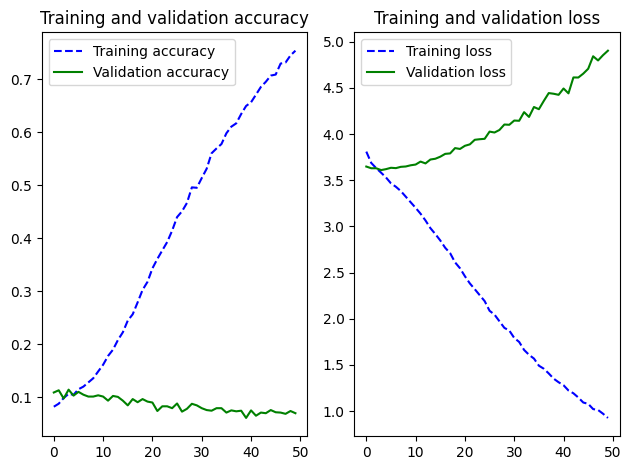

In [61]:
plot_training_analysis(vgg_mlp_history)

In [89]:
# Data Augmentation using ImageDataGenerator
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation aléatoire de 20 degrés
    width_shift_range=0.2,  # Décalage horizontal aléatoire de 20%
    height_shift_range=0.2,  # Décalage vertical aléatoire de 20%
    shear_range=0.2,  # Déformation par cisaillement aléatoire de 20%
    zoom_range=0.2,  # Zoom aléatoire de 20%
    horizontal_flip=True,  # Retournement horizontal aléatoire
    fill_mode='nearest'  # Méthode de remplissage pour les pixels manquants
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    "data/",
    x_col='filename',
    y_col='category',
    target_size=(img_width, img_height),
    class_mode='sparse',
    batch_size=batch_size
)

Found 5067 validated image filenames belonging to 50 classes.


In [98]:
val1_generator = val_datagen.flow_from_dataframe(
    val_df,
    "data/",
    x_col='filename',
    y_col='category',
    target_size=(img_width, img_height),
    class_mode='sparse',  # Assurez-vous que cela est bien 'sparse' dans les données de validation
    batch_size=batch_size
)

Found 1689 validated image filenames belonging to 50 classes.


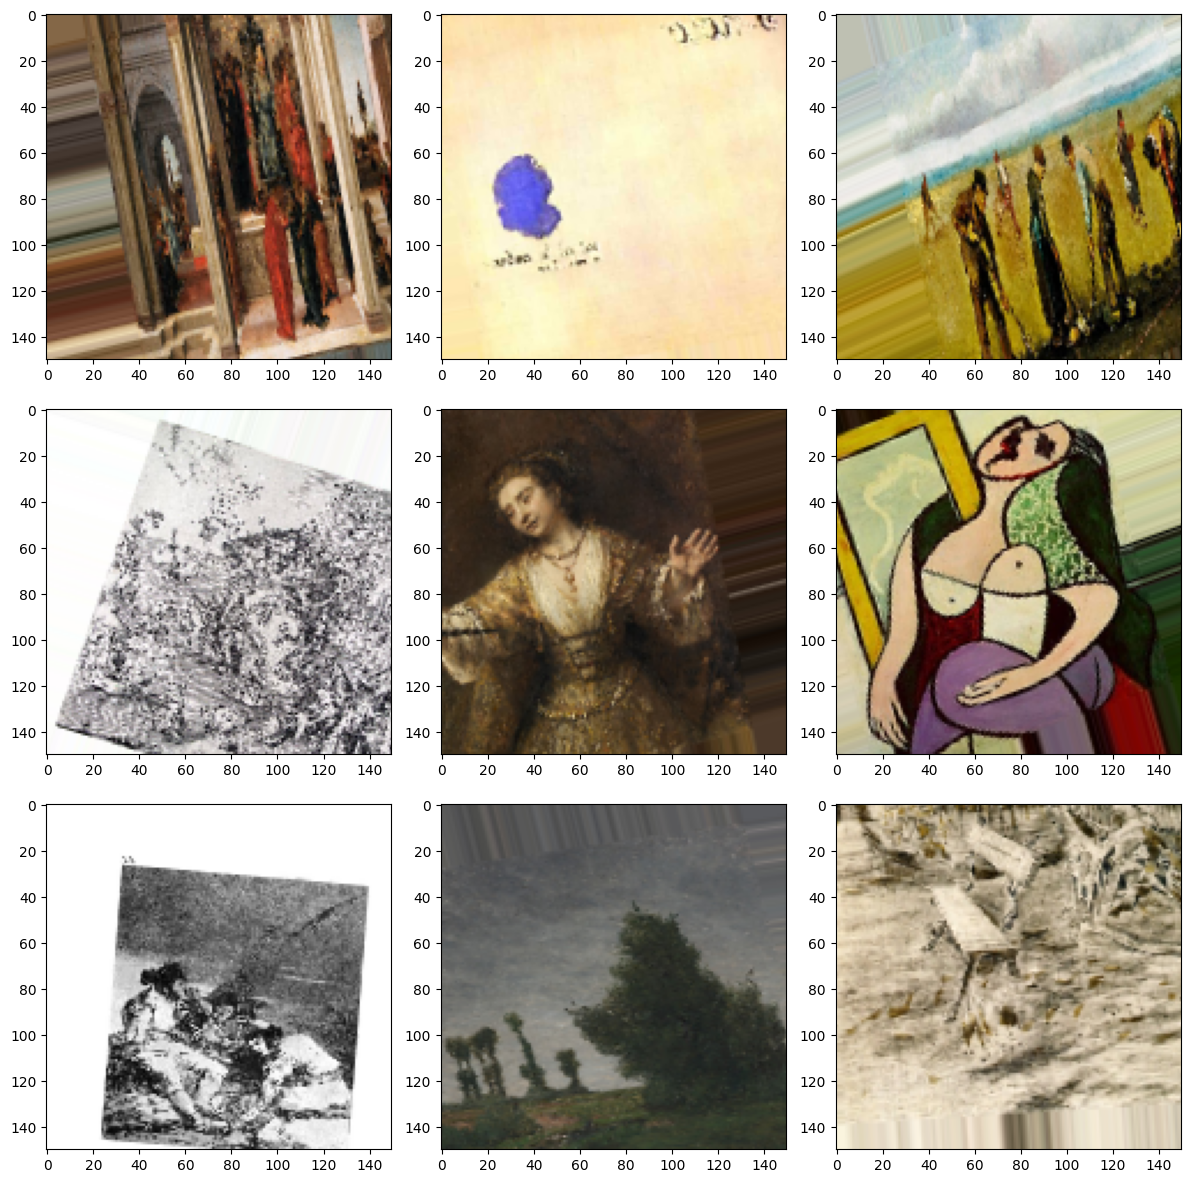

In [94]:
plt.figure(figsize=(12, 12))

example_x, example_y = next(train_generator_augmented)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_x[i])
    #plt.title(labels.get(example_y[i]))

plt.tight_layout()
plt.show()

In [100]:
train_features = conv_base.predict(train_generator_augmented)
train_features = np.reshape(train_features,(train_features.shape[0], -1))

validation_features = conv_base.predict(val1_generator)
validation_features = np.reshape(validation_features,(validation_features.shape[0], -1))

85/85 [==============================] - 8s 97ms/step


In [ ]:
vgg_combined = Sequential()
vgg_combined.add( Input((train_features.shape[1],)) )
#vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(50, activation='softmax'))

conv_base.trainable = False

vgg_combined.summary()

ValueError: Exception encountered when calling layer "vgg16" (type Functional).

Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 8192)

Call arguments received by layer "vgg16" (type Functional):
  • inputs=tf.Tensor(shape=(None, 8192), dtype=float32)
  • training=False
  • mask=None

In [111]:
epochs = 20

vgg_combined.compile(
    loss = 'SparseCategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_features, y_train,
    validation_data = (validation_features, y_validation),
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

Epoch 1/20
159/159 [==============================] - 1s 6ms/step - loss: 20.2755 - accuracy: 0.0000e+00 - val_loss: 20.2058 - val_accuracy: 0.0000e+00
Epoch 2/20
159/159 [==============================] - 1s 4ms/step - loss: 20.2755 - accuracy: 0.0000e+00 - val_loss: 20.2058 - val_accuracy: 0.0000e+00
Epoch 3/20
159/159 [==============================] - 1s 4ms/step - loss: 20.2755 - accuracy: 0.0000e+00 - val_loss: 20.2058 - val_accuracy: 0.0000e+00
Epoch 4/20
159/159 [==============================] - 1s 3ms/step - loss: 20.2755 - accuracy: 0.0000e+00 - val_loss: 20.2058 - val_accuracy: 0.0000e+00
Epoch 5/20
159/159 [==============================] - 1s 4ms/step - loss: 20.2755 - accuracy: 0.0000e+00 - val_loss: 20.2058 - val_accuracy: 0.0000e+00
Epoch 6/20
159/159 [==============================] - 1s 4ms/step - loss: 20.2755 - accuracy: 0.0000e+00 - val_loss: 20.2058 - val_accuracy: 0.0000e+00
Epoch 7/20
159/159 [==============================] - 1s 4ms/step - loss: 20.2755 - accu

In [109]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(val1_generator)

t_prediction_vgg_combined = time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined )

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_16/dense_30/MatMul' defined at (most recent call last):
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\phucl\AppData\Local\Temp\ipykernel_25544\352826440.py", line 3, in <module>
      score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\phucl\anaconda3\envs\tf-gpu\lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_16/dense_30/MatMul'
Matrix size-incompatible: In[0]: [20,67500], In[1]: [8192,256]
	 [[{{node sequential_16/dense_30/MatMul}}]] [Op:__inference_test_function_113043]

In [95]:
# Define the number of desired images per author
desired_images_per_author = 800

# Create a dictionary to store the number of images for each author
author_image_counts = {}
for author in total_df['category'].unique():
  author_image_counts[author] = 0

# Create a new directory for augmented images
augmented_data_dir = 'augmented_data'
if not os.path.exists(augmented_data_dir):
  os.makedirs(augmented_data_dir)


# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Loop through each author
for author in total_df['category'].unique():
  # Get a list of filenames for the current author
  author_filenames = total_df[total_df['category'] == author]['filename'].tolist()

  # Loop until the desired number of images is reached
  while author_image_counts[author] < desired_images_per_author:
    # Select a random image from the author's folder
    filename = rd.choice(author_filenames)
    img_path = os.path.join('data', filename)

    # Load the image and convert it to an array
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=augmented_data_dir,
                              save_prefix=author,
                              save_format='jpg'):
        i += 1
        author_image_counts[author] += 1
        if i > 10:  # Adjust this value to generate more/fewer augmented images per original image
          break

# Now, 'augmented_data_dir' contains the augmented images, with each author having approximately 'desired_images_per_author' images.
# You can then use this augmented dataset for training your model.

# For example:

# new_train_df = ... Create a new DataFrame using the images in 'augmented_data_dir' ...
# new_train_datagen = ImageDataGenerator(rescale=1./255)
# new_train_generator = new_train_datagen.flow_from_dataframe(...)

KeyboardInterrupt: 